# CNN

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np

In [ ]:
import torchvision
import torchvision.transforms as transforms
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                        download=True, transform=transforms.ToTensor())

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)

In [ ]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

print(images.shape)

print(images[0].shape)
print(labels[0].item())

torch.Size([4, 3, 32, 32])
torch.Size([3, 32, 32])
9


In [ ]:
img = images[1]
print(type(img))

<class 'torch.Tensor'>


In [ ]:
npimg = img.numpy()
print(npimg.shape)

(3, 32, 32)


In [ ]:
npimg = np.transpose(npimg, (1, 2, 0))
print(npimg.shape)

(32, 32, 3)


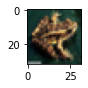

In [ ]:
plt.figure(figsize = (1,1))
plt.imshow(npimg)
plt.show()

In [ ]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

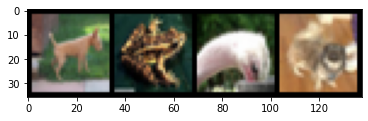

dog frog bird dog


In [ ]:
imshow(torchvision.utils.make_grid(images))
print(' '.join(classes[labels[j]] for j in range(4)))

In [ ]:
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self): 
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=(1,1), stride=(2,2)) # padding=(1,1), stride=(2,2))
        
    def forward(self, x):
        x = self.conv1(x)
        return x

In [ ]:
cnn = CNN()

In [ ]:
output = cnn(images)
output.shape

torch.Size([4, 16, 16, 16])

In [ ]:
for param in cnn.parameters():
    print(param.shape)

torch.Size([16, 3, 3, 3])
torch.Size([16])


In [ ]:
out1 = output[0, 0, :, :].detach().numpy()
print(out1.shape)

(16, 16)


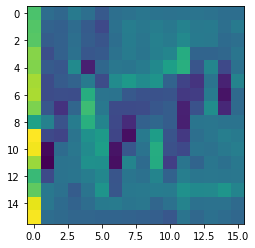

In [ ]:
plt.imshow(out1)
plt.show()

In [ ]:
class deepcnn(nn.Module):
    def __init__(self):
        super(deepcnn,self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 8, 3),   # (N, 3, 32, 32) -> (N, 8, 30, 30)
            nn.Conv2d(8, 16, 3)   # (N, 8, 30, 30) -> (N, 16, 28, 28)
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [ ]:
net = deepcnn()
out = net(images)
out.shape

torch.Size([4, 16, 28, 28])

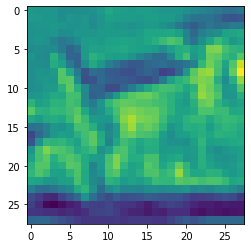

In [ ]:
plt.imshow(out[0, 0, :, :].detach().numpy())

In [ ]:
class deepercnn(nn.Module):
    def __init__(self): 
        super(deepercnn, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 6, 5),          # (N, 3, 32, 32) -> (N, 6, 28, 28)
            nn.AvgPool2d(2, stride=2),   # (N, 6, 28, 28) -> (N, 6, 14, 14)
            nn.Conv2d(6, 16, 5),         # (N, 6, 14, 14) -> (N, 16, 10, 10)
            nn.AvgPool2d(2, stride=2)    # (N, 16, 10, 10) -> (N, 16, 5, 5)
        )
        
    def forward(self, x):
        x = self.model(x)
        return x

In [ ]:
net = deepercnn()
out = net(images)
out.shape

torch.Size([4, 16, 5, 5])

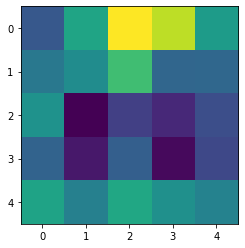

In [ ]:
plt.imshow(out[0, 0, :, :].detach().numpy())

# Tasks

1) Analysis on Model, Dataset, Number of Parameters Algorithm, Batch Normalization, Dropout, Activation Function, Regularization, Hyper Parameter Tuning, Architecture.

3) Try SPSA instead of Back Propagation

4) Add checkpoints to all the models

5) Read the paper with two Forward passes and no back propagation

# Basic Training Structure

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
from torch.utils.data.sampler import SubsetRandomSampler
from tqdm.notebook import tqdm

In [ ]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
def get_train_valid_loader(data_dir,
                           batch_size,
                           augment=False,
                           random_seed = 4,
                           valid_size=0.1,
                           shuffle=True,
                           show_sample=False,
                           num_workers=1):
    
    error_msg = "[!] valid_size should be in the range [0, 1]."
    assert ((valid_size >= 0) and (valid_size <= 1)), error_msg

    normalize = transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    )

    valid_transform = transforms.Compose([
            transforms.ToTensor(),
            normalize,
    ])
    if augment:
        train_transform = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
        ])
    else:
        train_transform = transforms.Compose([
            transforms.ToTensor(),
            normalize,
        ])

    # load the dataset
    train_dataset = torchvision.datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=train_transform,
    )

    valid_dataset = torchvision.datasets.CIFAR10(
        root=data_dir, train=True,
        download=True, transform=valid_transform,
    )

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler,
        num_workers=num_workers,
    )
    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size, sampler=valid_sampler,
        num_workers=num_workers,
    )

    # visualize some images
    if show_sample:
        sample_bz = 6
        sample_loader = torch.utils.data.DataLoader(
            train_dataset, batch_size=sample_bz,
            num_workers=num_workers, shuffle = False,
        )
        dataiter = iter(sample_loader)
        images, labels = next(dataiter)
        imshow(torchvision.utils.make_grid(images))
        print(' '.join(classes[labels[j]] for j in range(sample_bz)))

    return (train_loader, valid_loader)


In [ ]:
def get_test_loader(data_dir,
                    batch_size,
                    shuffle=False,
                    num_workers=1):
    
    normalize = transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
    )

    transform = transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ])

    dataset = torchvision.datasets.CIFAR10(
        root=data_dir, train=False,
        download=True, transform=transform,
    )

    data_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle,
        num_workers=num_workers,
    )

    return data_loader

Files already downloaded and verified
Files already downloaded and verified


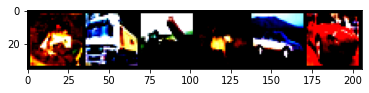

frog truck truck deer car car
Files already downloaded and verified


In [ ]:
train_bz = 64
(trainloader,validloader) = get_train_valid_loader('./data',train_bz,show_sample=True)
test_bz = 128
testloader = get_test_loader('./data',test_bz)

In [ ]:
print(len(trainloader),len(validloader),len(testloader))

704 79 79


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
def evaluation(model,dataloader):
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100 * correct / total

In [ ]:
import torch.optim as optim

loss_fn = nn.CrossEntropyLoss()

# Basic LeNet

In [ ]:
class LeNet(nn.Module):
    def __init__(self): 
        super(LeNet, self).__init__()
        self.cnn_model = nn.Sequential(
            nn.Conv2d(3, 6, 5),         # (N, 3, 32, 32) -> (N,  6, 28, 28)
            nn.Tanh(),
            nn.AvgPool2d(2, stride=2),  # (N, 6, 28, 28) -> (N,  6, 14, 14)
            nn.Conv2d(6, 16, 5),        # (N, 6, 14, 14) -> (N, 16, 10, 10)  
            nn.Tanh(),
            nn.AvgPool2d(2, stride=2)   # (N,16, 10, 10) -> (N, 16, 5, 5)
        )
        self.fc_model = nn.Sequential(
            nn.Linear(400,120),         # (N, 400) -> (N, 120)
            nn.Tanh(),
            nn.Linear(120,84),          # (N, 120) -> (N, 84)
            nn.Tanh(),
            nn.Linear(84,10)            # (N, 84)  -> (N, 10)
        )
        
    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1)
        x = self.fc_model(x)
        return x

In [ ]:
net = LeNet().to(device)

In [ ]:
from torchsummary import summary
summary(net,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
              Tanh-2            [-1, 6, 28, 28]               0
         AvgPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
              Tanh-5           [-1, 16, 10, 10]               0
         AvgPool2d-6             [-1, 16, 5, 5]               0
            Linear-7                  [-1, 120]          48,120
              Tanh-8                  [-1, 120]               0
            Linear-9                   [-1, 84]          10,164
             Tanh-10                   [-1, 84]               0
           Linear-11                   [-1, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/ba

In [ ]:
opt = optim.Adam(net.parameters(), lr = 5*1e-5)

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0/32, Train acc: 32.54, Valid acc: 33.20
Epoch: 1/32, Train acc: 35.92, Valid acc: 35.48
Epoch: 2/32, Train acc: 37.78, Valid acc: 37.14
Epoch: 3/32, Train acc: 38.93, Valid acc: 38.00
Epoch: 4/32, Train acc: 40.07, Valid acc: 39.24
Epoch: 5/32, Train acc: 40.98, Valid acc: 40.12
Epoch: 6/32, Train acc: 41.92, Valid acc: 40.80
Epoch: 7/32, Train acc: 42.66, Valid acc: 41.36
Epoch: 8/32, Train acc: 43.26, Valid acc: 42.02
Epoch: 9/32, Train acc: 43.82, Valid acc: 42.66
Epoch: 10/32, Train acc: 44.58, Valid acc: 43.58
Epoch: 11/32, Train acc: 45.08, Valid acc: 44.08
Epoch: 12/32, Train acc: 45.71, Valid acc: 44.44
Epoch: 13/32, Train acc: 46.22, Valid acc: 44.96
Epoch: 14/32, Train acc: 46.63, Valid acc: 45.58
Epoch: 15/32, Train acc: 47.19, Valid acc: 46.10
Epoch: 16/32, Train acc: 47.71, Valid acc: 46.28
Epoch: 17/32, Train acc: 48.13, Valid acc: 46.66
Epoch: 18/32, Train acc: 48.66, Valid acc: 47.28
Epoch: 19/32, Train acc: 49.13, Valid acc: 47.86
Epoch: 20/32, Train acc: 49.82

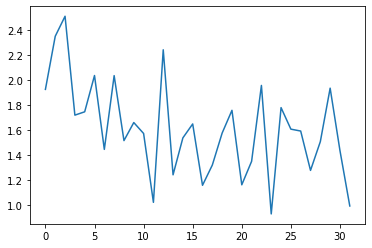

In [ ]:
loss_arr = []
loss_epoch_arr = []
train_acc_arr = []
valid_acc_arr = []
max_epochs = 32

for epoch in tqdm(range(max_epochs)):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = net(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
        loss_arr.append(loss.item())
        
    loss_epoch_arr.append(loss.item())

    with torch.no_grad():
        trainacc = evaluation(net,trainloader)
        validacc = evaluation(net,validloader)
        train_acc_arr.append(trainacc)
        valid_acc_arr.append(validacc)
        print('Epoch: %d/%d, Train acc: %0.2f, Valid acc: %0.2f' % (epoch, max_epochs, trainacc, validacc))
    
plt.plot(loss_epoch_arr)
plt.show()

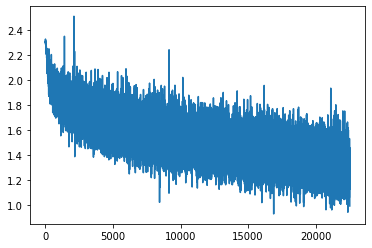

In [ ]:
plt.plot(loss_arr)
plt.show()

In [ ]:
net.eval()
testacc = evaluation(net,testloader)
print('Test acc: %0.2f' % (testacc))

Test acc: 52.14


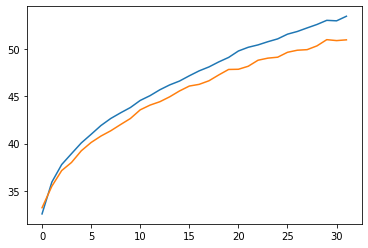

In [ ]:
plt.plot(train_acc_arr)
plt.plot(valid_acc_arr)
plt.show()

In [ ]:
print('Test acc: %0.2f, Valid acc: %0.2f, Train acc: %0.2f' % (evaluation(net,testloader), evaluation(net,validloader), evaluation(net,trainloader)))

Test acc: 52.14, Valid acc: 51.00, Train acc: 53.50


# LeNet with Normalization

In [ ]:
class LeNetBN(nn.Module):
    def __init__(self): 
        super(LeNetBN, self).__init__()
        self.cnn_model = nn.Sequential(
            nn.Conv2d(3, 6, 5),         # (N, 3, 32, 32) -> (N,  6, 28, 28)
            nn.Tanh(),
            nn.BatchNorm2d(6),
            nn.AvgPool2d(2, stride=2),  # (N, 6, 28, 28) -> (N,  6, 14, 14)
            nn.Conv2d(6, 16, 5),        # (N, 6, 14, 14) -> (N, 16, 10, 10)  
            nn.Tanh(),
            nn.BatchNorm2d(16),
            nn.AvgPool2d(2, stride=2)   # (N,16, 10, 10) -> (N, 16, 5, 5)
        )
        self.fc_model = nn.Sequential(
            nn.Linear(400,120),         # (N, 400) -> (N, 120)
            nn.Tanh(),
            nn.BatchNorm1d(120),
            nn.Linear(120,84),          # (N, 120) -> (N, 84)
            nn.Tanh(),
            nn.BatchNorm1d(84),
            nn.Linear(84,10)            # (N, 84)  -> (N, 10)
        )
        
    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1)
        x = self.fc_model(x)
        return x

In [ ]:
BNLeNet = LeNetBN().to(device)

In [ ]:
from torchsummary import summary
summary(net,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
              Tanh-2            [-1, 6, 28, 28]               0
         AvgPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
              Tanh-5           [-1, 16, 10, 10]               0
         AvgPool2d-6             [-1, 16, 5, 5]               0
            Linear-7                  [-1, 120]          48,120
              Tanh-8                  [-1, 120]               0
            Linear-9                   [-1, 84]          10,164
             Tanh-10                   [-1, 84]               0
           Linear-11                   [-1, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/ba

In [ ]:
opt = optim.Adam(BNLeNet.parameters())

In [ ]:
from tqdm.notebook import tqdm

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0/10, Train acc: 49.26, Valid acc: 47.76
Epoch: 1/10, Train acc: 54.64, Valid acc: 51.30
Epoch: 2/10, Train acc: 57.71, Valid acc: 53.10
Epoch: 3/10, Train acc: 61.55, Valid acc: 56.08
Epoch: 4/10, Train acc: 63.41, Valid acc: 57.04
Epoch: 5/10, Train acc: 66.56, Valid acc: 57.62
Epoch: 6/10, Train acc: 68.57, Valid acc: 59.48
Epoch: 7/10, Train acc: 69.54, Valid acc: 58.10
Epoch: 8/10, Train acc: 71.06, Valid acc: 58.72
Epoch: 9/10, Train acc: 71.60, Valid acc: 58.12


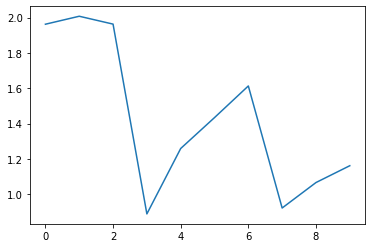

In [ ]:
from tqdm.notebook import tqdm

loss_arr = []
loss_epoch_arr = []
train_acc_arr = []
valid_acc_arr = []
max_epochs = 10

for epoch in tqdm(range(max_epochs)):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = BNLeNet(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
        loss_arr.append(loss.item())
        
    loss_epoch_arr.append(loss.item())

    with torch.no_grad():
        trainacc = evaluation(BNLeNet,trainloader)
        validacc = evaluation(BNLeNet,validloader)
        train_acc_arr.append(trainacc)
        valid_acc_arr.append(validacc)
        print('Epoch: %d/%d, Train acc: %0.2f, Valid acc: %0.2f' % (epoch, max_epochs, trainacc, validacc))
    
plt.plot(loss_epoch_arr)
plt.show()

In [ ]:
BNLeNet.eval()
testacc = evaluation(BNLeNet,testloader)
print('Test acc: %0.2f' % (testacc))

Test acc: 59.26


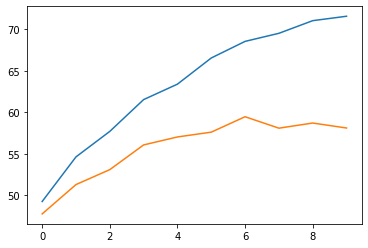

In [ ]:
plt.plot(train_acc_arr)
plt.plot(valid_acc_arr)
plt.show()

In [ ]:
print('Test acc: %0.2f, Valid acc: %0.2f, Train acc: %0.2f' % (evaluation(BNLeNet,testloader), evaluation(BNLeNet,validloader), evaluation(BNLeNet,trainloader)))

Test acc: 59.26, Valid acc: 59.08, Train acc: 73.31


# LeNet with DropOut

In [ ]:
class LeNetDrop(nn.Module):
    def __init__(self): 
        super(LeNetDrop, self).__init__()
        self.cnn_model = nn.Sequential(
            nn.Dropout(0.2),
            nn.Conv2d(3, 6, 5),         # (N, 3, 32, 32) -> (N,  6, 28, 28)
            nn.Tanh(),
            nn.Dropout(0.5),
            nn.AvgPool2d(2, stride=2),  # (N, 6, 28, 28) -> (N,  6, 14, 14)
            nn.Conv2d(6, 16, 5),        # (N, 6, 14, 14) -> (N, 16, 10, 10)  
            nn.Tanh(),
            nn.Dropout(0.5),
            nn.AvgPool2d(2, stride=2)   # (N,16, 10, 10) -> (N, 16, 5, 5)
        )
        self.fc_model = nn.Sequential(
            nn.Linear(400,120),         # (N, 400) -> (N, 120)
            nn.Tanh(),
            nn.Dropout(0.5),
            nn.Linear(120,84),          # (N, 120) -> (N, 84)
            nn.Tanh(),
            nn.Dropout(0.5),
            nn.Linear(84,10)            # (N, 84)  -> (N, 10)
        )
        
    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1)
        x = self.fc_model(x)
        return x

In [ ]:
DropLeNet = LeNetDrop().to(device)

In [ ]:
from torchsummary import summary
summary(net,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Dropout-1            [-1, 3, 32, 32]               0
            Conv2d-2            [-1, 6, 28, 28]             456
              Tanh-3            [-1, 6, 28, 28]               0
           Dropout-4            [-1, 6, 28, 28]               0
         AvgPool2d-5            [-1, 6, 14, 14]               0
            Conv2d-6           [-1, 16, 10, 10]           2,416
              Tanh-7           [-1, 16, 10, 10]               0
           Dropout-8           [-1, 16, 10, 10]               0
         AvgPool2d-9             [-1, 16, 5, 5]               0
           Linear-10                  [-1, 120]          48,120
             Tanh-11                  [-1, 120]               0
          Dropout-12                  [-1, 120]               0
           Linear-13                   [-1, 84]          10,164
             Tanh-14                   

In [ ]:
opt = optim.Adam(DropLeNet.parameters(), lr = 1e-4)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0/10, Train acc: 36.24, Valid acc: 36.14
Epoch: 1/10, Train acc: 38.48, Valid acc: 38.20
Epoch: 2/10, Train acc: 40.19, Valid acc: 39.44
Epoch: 3/10, Train acc: 41.38, Valid acc: 41.62
Epoch: 4/10, Train acc: 42.76, Valid acc: 42.34
Epoch: 5/10, Train acc: 42.82, Valid acc: 42.36
Epoch: 6/10, Train acc: 44.17, Valid acc: 43.80
Epoch: 7/10, Train acc: 44.00, Valid acc: 42.86
Epoch: 8/10, Train acc: 44.35, Valid acc: 42.94
Epoch: 9/10, Train acc: 44.76, Valid acc: 43.38


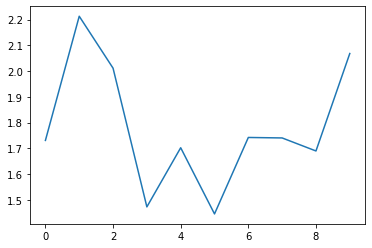

In [ ]:
loss_arr = []
loss_epoch_arr = []
train_acc_arr = []
valid_acc_arr = []
max_epochs = 16

for epoch in tqdm(range(max_epochs)):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = DropLeNet(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
        loss_arr.append(loss.item())
        
    loss_epoch_arr.append(loss.item())

    with torch.no_grad():
        trainacc = evaluation(DropLeNet,trainloader)
        validacc = evaluation(DropLeNet,validloader)
        train_acc_arr.append(trainacc)
        valid_acc_arr.append(validacc)
        print('Epoch: %d/%d, Train acc: %0.2f, Valid acc: %0.2f' % (epoch, max_epochs, trainacc, validacc))
    
plt.plot(loss_epoch_arr)
plt.show()

In [ ]:
DropLeNet.eval()
testacc = evaluation(DropLeNet,testloader)
print('Test acc: %0.2f' % (testacc))

Test acc: 50.88


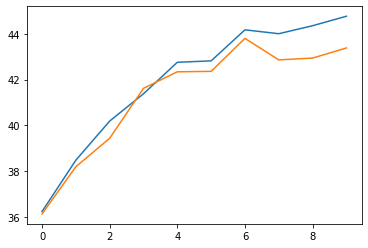

In [ ]:
plt.plot(train_acc_arr)
plt.plot(valid_acc_arr)
plt.show()

In [ ]:
print('Test acc: %0.2f, Valid acc: %0.2f, Train acc: %0.2f' % (evaluation(DropLeNet,testloader), evaluation(DropLeNet,validloader), evaluation(DropLeNet,trainloader)))

Test acc: 50.88, Valid acc: 49.48, Train acc: 51.49


# LeNet with Normalization and DropOut

In [ ]:
class LeNetBND(nn.Module):
    def __init__(self): 
        super(LeNetBND, self).__init__()
        self.cnn_model = nn.Sequential(
            nn.Dropout(0.2),
            nn.Conv2d(3, 6, 5),         # (N, 3, 32, 32) -> (N,  6, 28, 28)
            nn.Tanh(),
            nn.BatchNorm2d(6),
            nn.Dropout(0.5),
            nn.AvgPool2d(2, stride=2),  # (N, 6, 28, 28) -> (N,  6, 14, 14)
            nn.Conv2d(6, 16, 5),        # (N, 6, 14, 14) -> (N, 16, 10, 10)  
            nn.Tanh(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.5),
            nn.AvgPool2d(2, stride=2)   # (N,16, 10, 10) -> (N, 16, 5, 5)
        )
        self.fc_model = nn.Sequential(
            nn.Linear(400,120),         # (N, 400) -> (N, 120)
            nn.Tanh(),
            nn.BatchNorm1d(120),
            nn.Dropout(0.2),
            nn.Linear(120,84),          # (N, 120) -> (N, 84)
            nn.Tanh(),
            nn.BatchNorm1d(84),
            nn.Dropout(0.2),
            nn.Linear(84,10)            # (N, 84)  -> (N, 10)
        )
        
    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1)
        x = self.fc_model(x)
        return x

In [ ]:
BNDLeNet = LeNetBND().to(device)

In [ ]:
from torchsummary import summary
summary(net,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Dropout-1            [-1, 3, 32, 32]               0
            Conv2d-2            [-1, 6, 28, 28]             456
              Tanh-3            [-1, 6, 28, 28]               0
       BatchNorm2d-4            [-1, 6, 28, 28]              12
           Dropout-5            [-1, 6, 28, 28]               0
         AvgPool2d-6            [-1, 6, 14, 14]               0
            Conv2d-7           [-1, 16, 10, 10]           2,416
              Tanh-8           [-1, 16, 10, 10]               0
       BatchNorm2d-9           [-1, 16, 10, 10]              32
          Dropout-10           [-1, 16, 10, 10]               0
        AvgPool2d-11             [-1, 16, 5, 5]               0
           Linear-12                  [-1, 120]          48,120
             Tanh-13                  [-1, 120]               0
      BatchNorm1d-14                  [

In [ ]:
opt = optim.Adam(BNDLeNet.parameters())

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0/10, Train acc: 39.33, Valid acc: 38.60
Epoch: 1/10, Train acc: 45.26, Valid acc: 43.82
Epoch: 2/10, Train acc: 47.18, Valid acc: 45.78
Epoch: 3/10, Train acc: 47.87, Valid acc: 46.32
Epoch: 4/10, Train acc: 49.20, Valid acc: 47.54
Epoch: 5/10, Train acc: 49.90, Valid acc: 48.30
Epoch: 6/10, Train acc: 50.84, Valid acc: 48.40
Epoch: 7/10, Train acc: 51.26, Valid acc: 47.64
Epoch: 8/10, Train acc: 51.26, Valid acc: 48.88
Epoch: 9/10, Train acc: 51.64, Valid acc: 49.22


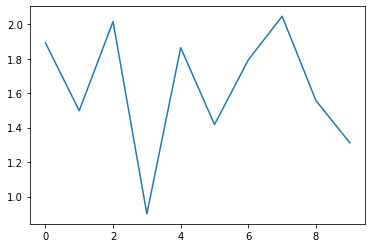

In [ ]:
loss_arr = []
loss_epoch_arr = []
train_acc_arr = []
valid_acc_arr = []
max_epochs = 10

for epoch in tqdm(range(max_epochs)):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = BNDLeNet(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
        loss_arr.append(loss.item())
        
    loss_epoch_arr.append(loss.item())

    with torch.no_grad():
        trainacc = evaluation(BNDLeNet,trainloader)
        validacc = evaluation(BNDLeNet,validloader)
        train_acc_arr.append(trainacc)
        valid_acc_arr.append(validacc)
        print('Epoch: %d/%d, Train acc: %0.2f, Valid acc: %0.2f' % (epoch, max_epochs, trainacc, validacc))
    
plt.plot(loss_epoch_arr)
plt.show()

In [ ]:
BNDLeNet.eval()
testacc = evaluation(BNDLeNet,testloader)
print('Test acc: %0.2f' % (testacc))

Test acc: 55.76


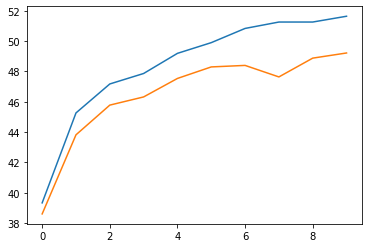

In [ ]:
plt.plot(train_acc_arr)
plt.plot(valid_acc_arr)
plt.show()

In [ ]:
print('Test acc: %0.2f, Valid acc: %0.2f, Train acc: %0.2f' % (evaluation(BNDLeNet,testloader), evaluation(BNDLeNet,validloader), evaluation(BNDLeNet,trainloader)))

Test acc: 55.76, Valid acc: 54.44, Train acc: 58.29


# LeNet with Regularization, Batch Normalization and Dropout and ReLU activation

In [ ]:
class LeNetMix(nn.Module):
    def __init__(self): 
        super(LeNetMix, self).__init__()
        self.cnn_model = nn.Sequential(
            nn.Dropout(0.2),
            nn.Conv2d(3, 6, 5),         # (N, 3, 32, 32) -> (N,  6, 28, 28)
            nn.ReLU(),
            nn.BatchNorm2d(6),
            nn.AvgPool2d(2, stride=2),  # (N, 6, 28, 28) -> (N,  6, 14, 14)
            nn.Conv2d(6, 16, 5),        # (N, 6, 14, 14) -> (N, 16, 10, 10)  
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(0.5),
            nn.AvgPool2d(2, stride=2)   # (N,16, 10, 10) -> (N, 16, 5, 5)
        )
        self.fc_model = nn.Sequential(
            nn.Linear(400,120),         # (N, 400) -> (N, 120)
            nn.ReLU(),
            nn.BatchNorm1d(120),
            nn.Dropout(0.2),
            nn.Linear(120,84),          # (N, 120) -> (N, 84)
            nn.ReLU(),
            nn.BatchNorm1d(84),
            nn.Linear(84,10)            # (N, 84)  -> (N, 10)
        )
        
    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1)
        x = self.fc_model(x)
        return x

In [ ]:
MixLeNet = LeNetMix().to(device)

In [ ]:
from torchsummary import summary
summary(MixLeNet,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Dropout-1            [-1, 3, 32, 32]               0
            Conv2d-2            [-1, 6, 28, 28]             456
              ReLU-3            [-1, 6, 28, 28]               0
       BatchNorm2d-4            [-1, 6, 28, 28]              12
         AvgPool2d-5            [-1, 6, 14, 14]               0
            Conv2d-6           [-1, 16, 10, 10]           2,416
              ReLU-7           [-1, 16, 10, 10]               0
       BatchNorm2d-8           [-1, 16, 10, 10]              32
           Dropout-9           [-1, 16, 10, 10]               0
        AvgPool2d-10             [-1, 16, 5, 5]               0
           Linear-11                  [-1, 120]          48,120
             ReLU-12                  [-1, 120]               0
      BatchNorm1d-13                  [-1, 120]             240
          Dropout-14                  [

In [ ]:
opt = optim.Adam(MixLeNet.parameters(),lr = 5*1e-5, weight_decay = 0.01)
# default lr = 1e-3

  0%|          | 0/32 [00:00<?, ?it/s]

Epoch: 0/32, Train acc: 30.44, Valid acc: 30.60
Epoch: 1/32, Train acc: 36.31, Valid acc: 36.48
Epoch: 2/32, Train acc: 40.22, Valid acc: 38.78
Epoch: 3/32, Train acc: 42.41, Valid acc: 41.68
Epoch: 4/32, Train acc: 43.80, Valid acc: 44.16
Epoch: 5/32, Train acc: 45.29, Valid acc: 43.44
Epoch: 6/32, Train acc: 46.48, Valid acc: 45.18
Epoch: 7/32, Train acc: 47.20, Valid acc: 45.74
Epoch: 8/32, Train acc: 47.98, Valid acc: 46.78
Epoch: 9/32, Train acc: 48.66, Valid acc: 47.46
Epoch: 10/32, Train acc: 49.24, Valid acc: 48.82
Epoch: 11/32, Train acc: 50.12, Valid acc: 49.00
Epoch: 12/32, Train acc: 50.84, Valid acc: 48.80
Epoch: 13/32, Train acc: 51.46, Valid acc: 49.84
Epoch: 14/32, Train acc: 51.47, Valid acc: 49.26
Epoch: 15/32, Train acc: 51.95, Valid acc: 50.32
Epoch: 16/32, Train acc: 52.46, Valid acc: 50.28
Epoch: 17/32, Train acc: 52.69, Valid acc: 50.84
Epoch: 18/32, Train acc: 53.21, Valid acc: 50.62
Epoch: 19/32, Train acc: 53.62, Valid acc: 50.60
Epoch: 20/32, Train acc: 53.75

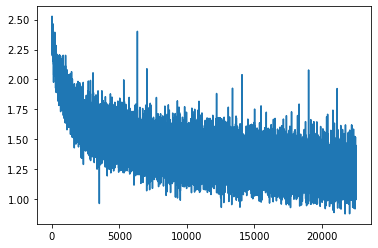

In [ ]:
loss_arr = []
loss_epoch_arr = []
train_acc_arr = []
valid_acc_arr = []
max_epochs = 32

for epoch in tqdm(range(max_epochs)):
    
    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = MixLeNet(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
        loss_arr.append(loss.item())
        
    loss_epoch_arr.append(loss.item())

    with torch.no_grad():
        trainacc = evaluation(MixLeNet,trainloader)
        validacc = evaluation(MixLeNet,validloader)
        train_acc_arr.append(trainacc)
        valid_acc_arr.append(validacc)
        print('Epoch: %d/%d, Train acc: %0.2f, Valid acc: %0.2f' % (epoch, max_epochs, trainacc, validacc))
    
plt.plot(loss_arr)
plt.show()

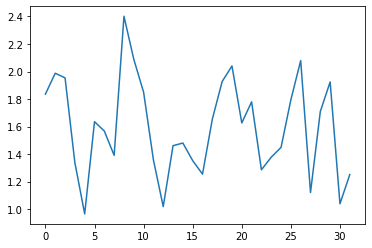

In [ ]:
plt.plot(loss_epoch_arr)
plt.show()

In [ ]:
MixLeNet.eval()
testacc = evaluation(MixLeNet,testloader)
print('Test acc: %0.2f' % (testacc))

Test acc: 55.23


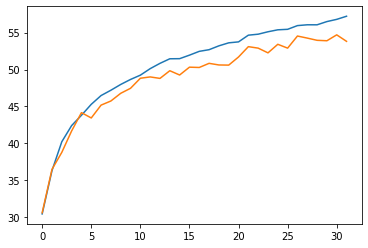

In [ ]:
plt.plot(train_acc_arr)
plt.plot(valid_acc_arr)
plt.show()

In [ ]:
print('Test acc: %0.2f, Valid acc: %0.2f, Train acc: %0.2f' % (evaluation(MixLeNet,testloader), evaluation(MixLeNet,validloader), evaluation(MixLeNet,trainloader)))

Test acc: 55.23, Valid acc: 55.58, Train acc: 59.01
